# Treasury PCA

Diego Alvarez

This model will decompose the Treasury Yield Curve using PCA. With dimensionality reduction techniques like PCA, we are able to conserve a good amount of the varaition will keeping only a few principle components. This is a well understood notion within finance, and it widely evident since most models used in practice are 2-3 three factors at most. Decomposing the yield curve allows us to get the fitted values and find the residuals, and then we are able to calculate their z-score thus giving a cheapness vs. richness relative value.

For ease of use this notebook is created to be fully replicable, and thus the data is downloaded from FRED (St. Louis Federal Reserve)

## Packages

In [9]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader as web

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

## Collect Data

In [4]:
try:

    df_rates = pd.read_parquet(
        path = "treasury_rates.parquet",
        engine = "pyarrow")
    
    print("found treasury info")

except:

    tickers = ["DGS1", "DGS2", "DGS3", "DGS5", "DGS7", "DGS10"]
    end_date = dt.date(year = 2023, month = 3, day = 29)
    start_date = end_date - dt.timedelta(days = 365 * 20)
    df_raw = web.DataReader(
      tickers,
      data_source = "fred",
      start = start_date, 
      end = end_date)

    df_raw.to_parquet(
        path = "treasury_rates.parquet",
        engine = "pyarrow")

    print("collectd from FRED")

collectd from FRED


## Plotting the data

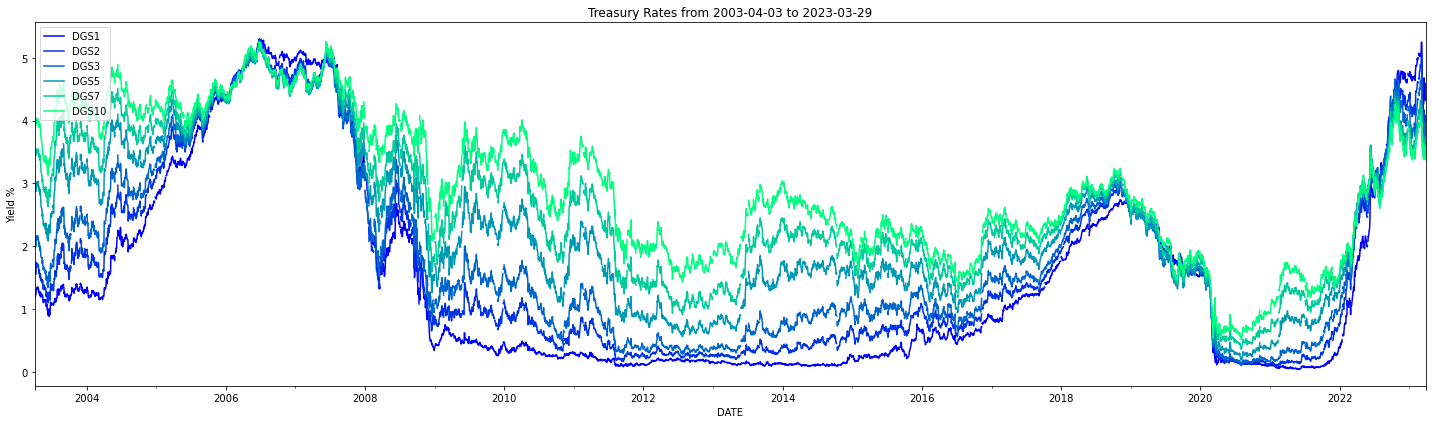

In [44]:
cmap = plt.get_cmap("winter")
colors = [cmap(i) for i in np.linspace(0, 1, df_raw.shape[1])]

(df_raw.plot(
    figsize = (20,6),
    ylabel = "Yield %",
    color = colors,
    title = "Treasury Rates from {} to {}".format(
        df_raw.index.min().date(), df_raw.index.max().date())))

plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()

## Making the PCA model

We are going to use 3 factors as previously stated. We'll find that these three factors describe a the variation relatively well. It is also noteworthy to mention that using more than 3 factors is not beneficial within this context since higher principal component aren't well defined in rates trading.

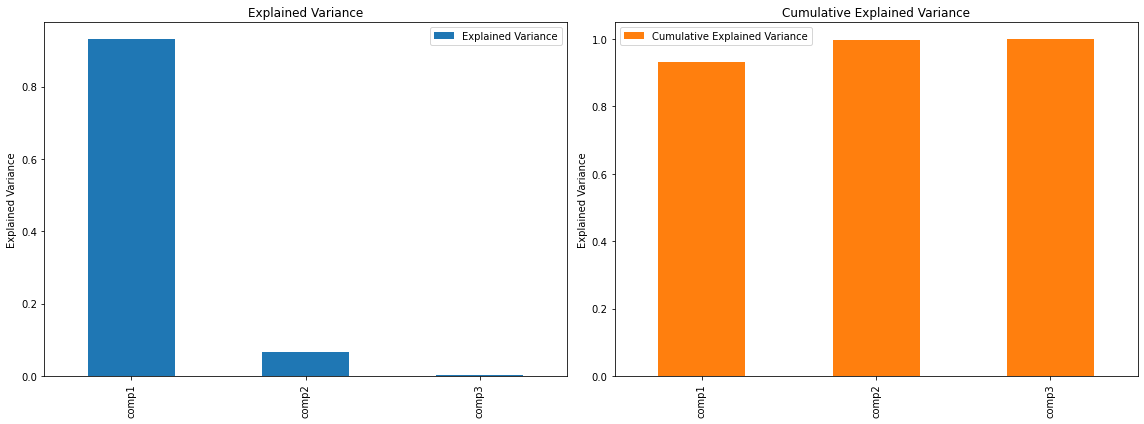

In [35]:
pca = PCA(n_components = 3)

(pd.DataFrame(
    {"explained_variance": pca.fit(df_raw.dropna()).explained_variance_ratio_},
    index = ["comp1", "comp2", "comp3"]).
    assign(cum_variance = lambda x: x.explained_variance.cumsum()).
    rename(columns = {
        "explained_variance": "Explained Variance",
        "cum_variance": "Cumulative Explained Variance"}).
    plot(
        subplots = True, layout = (1, 2),
        kind = "bar", 
        figsize = (16, 6),
        ylabel = "Explained Variance"))

plt.tight_layout()
plt.show()

In [42]:
pca_model = pca.fit_transform(df_raw.dropna())

In [43]:
pca_transform = (pd.DataFrame(
    pca_transform,
    columns = ["PC1", "PC2", "PC3"],
    index = df_raw.dropna().index))

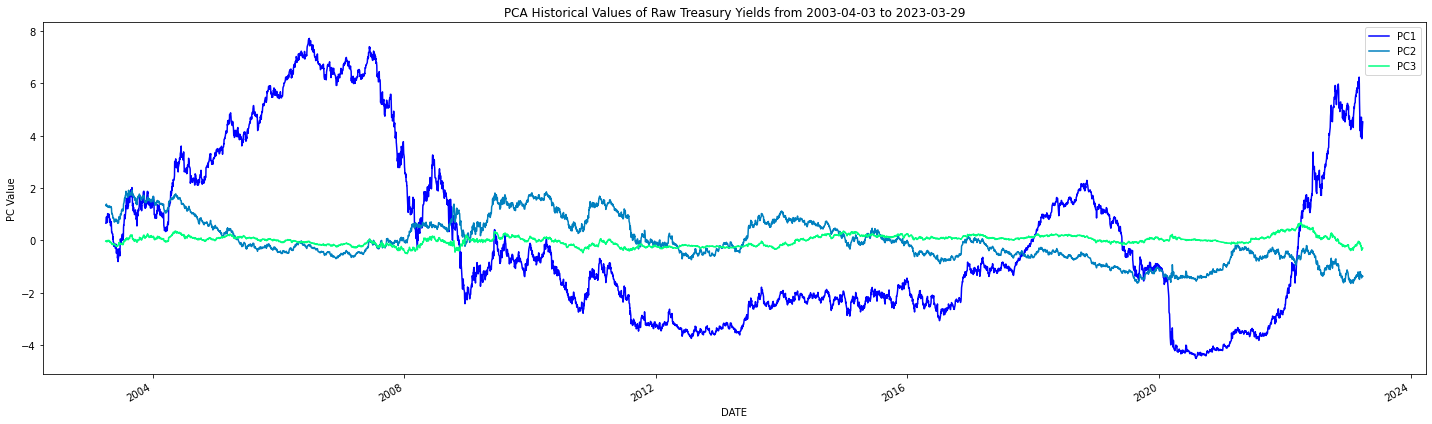

In [53]:
cmap = plt.get_cmap("winter")
colors = [cmap(i) for i in np.linspace(0, 1, pca_transform.shape[1])]

(pca_transform.plot(
    figsize = (20,6),
    ylabel = "PC Value",
    color = colors,
    title = "PCA Historical Values of Raw Treasury Yields from {} to {}".format(
        df_raw.dropna().index.min().date(), df_raw.dropna().index.max().date())))

plt.tight_layout()
plt.show()

In [54]:
fitted_values = pca.inverse_transform(pca_model)

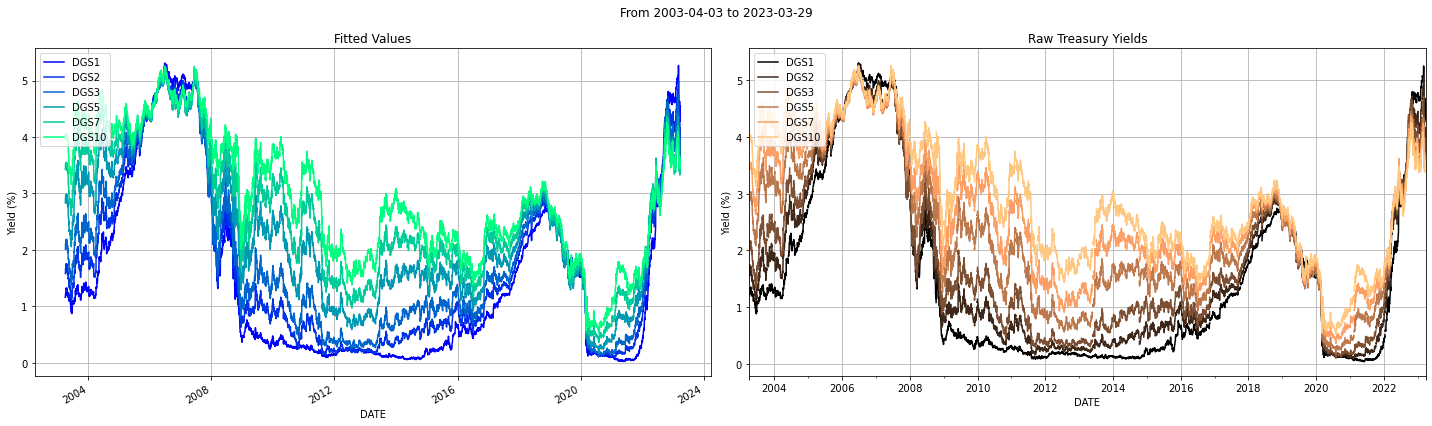

In [67]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))

blue_cmap = plt.get_cmap("winter")
blues_colors = [blue_cmap(i) for i in np.linspace(0, 1, df_raw.shape[1])]

red_cmap = plt.get_cmap("copper")
red_colors = [red_cmap(i) for i in np.linspace(0, 1, df_raw.shape[1])]

(pd.DataFrame(
    fitted_values,
    columns = df_raw.columns,
    index = df_raw.dropna().index).
    plot(
        color = blues_colors,
        ax = axes[0], grid = True,
        ylabel = "Yield (%)",
        title = "Fitted Values"))

(df_raw.plot(
    ax = axes[1], grid = True,
    ylabel = "Yield (%)",
    color = red_colors,
    title = "Raw Treasury Yields"))

fig.suptitle("From {} to {}".format(
    df_raw.dropna().index.min().date(), df_raw.dropna().index.max().date()))

axes[0].legend(loc = "upper left")
axes[1].legend(loc = "upper left")

plt.tight_layout()
plt.show()

In [68]:
residuals = df_raw.dropna() - fitted_values

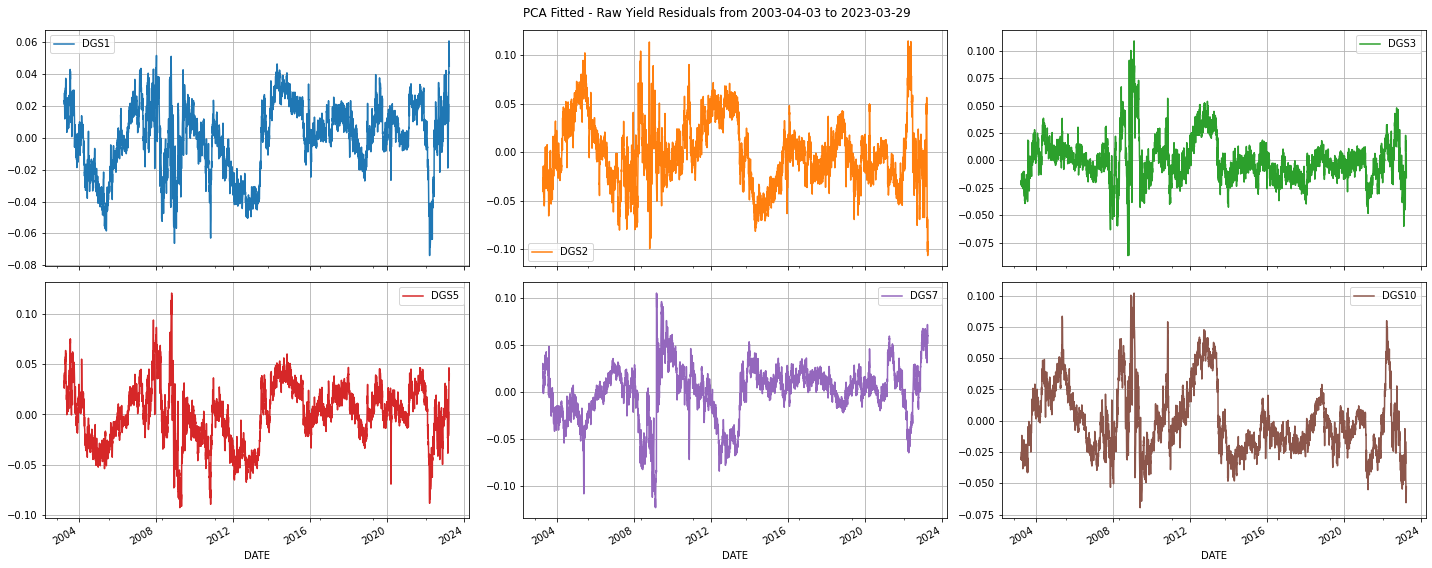

In [69]:
(residuals.plot(
    subplots = True, layout = (2, 3),
    grid = True,
    title = "PCA Fitted - Raw Yield Residuals from {} to {}".format(
        residuals.index.min().date(), residuals.index.max().date()),
    figsize = (20,8)))

plt.tight_layout()
plt.show()

Need to get the 3 month window for the z-score

In [72]:
last_date = residuals.index.max().date()
lookback_date = last_date - dt.timedelta(days = 90)

residuals_window = (residuals.query(
    "DATE > @lookback_date"))

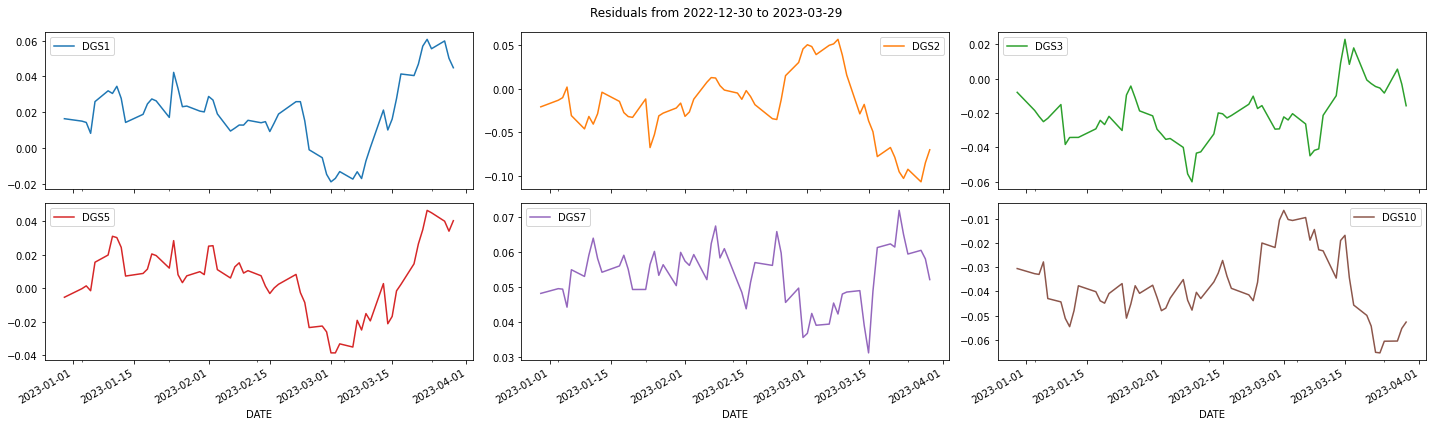

In [73]:
residuals_window.plot(
    subplots = True, layout = (2, 3),
    figsize = (20, 6), 
    title = "Residuals from {} to {}".format(
        residuals_window.index.min().date(), residuals_window.index.max().date()))

plt.tight_layout()
plt.show()

In [74]:
residuals_zscores_window = (residuals_window - residuals_window.mean()) / residuals_window.std()

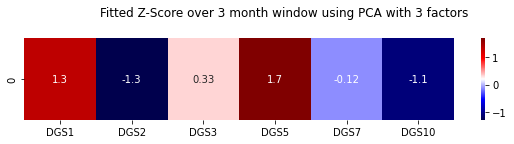

In [77]:
fig, axes = plt.subplots(figsize = (8,2))

sns.heatmap(residuals_zscores_window.query(
    "DATE == DATE.max()").
    reset_index(drop = True),
    cmap  = "seismic",
    annot = True,
    ax = axes)

fig.suptitle("Fitted Z-Score over 3 month window using PCA with 3 factors")
plt.tight_layout()